<a href="https://www.pieriandata.com"><img src="../DATA/Logo.jpg"></a>
*Copyright by Pierian Data Inc.*

# Custom Seeds with the WaterShed Algorithm

Previously we did a lot of work for OpenCV to set Markers to provide seeds to the Watershed Algorithm. But what if we just provide seeds ourselves? Let's try it out!

## Imports

In [2]:
import cv2
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

### Read in the Image and Make a Copy

In [4]:
road = cv2.imread('../DATA/road_image.jpg')
road = cv2.cvtColor(road, cv2.COLOR_BGR2RGB)
road_copy = np.copy(road)

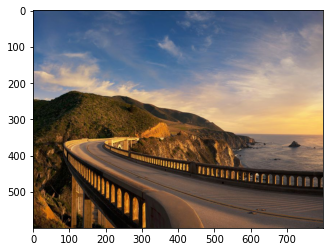

In [5]:
plt.imshow(road)

#### Create an empty space for the results to be drawn

We will create to matrices (images): one is where we will store the marker regions gotten by the watershed algorithm; and the another is to show the marker regions (segmentetions). The first one is an auxiliar matrix since we want to show the marker with colors and not in grayscale as watershed outputs.

**Note:**
- **uint (unsigned integer):** It is only for positive values (there is no negative values in uint). It is only use uint if your values are always positive.
- **int:** All integer values.

In [6]:
road.shape

(600, 800, 3)

In [7]:
road.shape[:2]

(600, 800)

For watershed algorithm, we need to use a grayscale image; so, we need just the height and width values:

In [8]:
marker_image = np.zeros(road.shape[:2],dtype=np.int32)

As we want to color the markers by ```tab10``` options, instead of grayscales, we need a black image with the same size as *raod image*:

In [9]:
segments = np.zeros(road.shape,dtype=np.uint8)

In [10]:
segments.shape

(600, 800, 3)

### Create colors for Markers

To have a variety of colors for markers, we can use the options of the following [link](https://matplotlib.org/examples/color/colormaps_reference.html). The choise for this work is ```tab10```, as its name suggests: it has ten options for colors.

First, import the ```cm``` module from ```matplotlib``` library.

In [11]:
from matplotlib import cm

Let's take a look into the values of some colors in ```tab10```:

In [12]:
cm.tab10(0)

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)

In [13]:
cm.tab10(1)

(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)

See what kind of object it is and what kind of objects it contains:

In [14]:
type(cm.tab10)

matplotlib.colors.ListedColormap

In [15]:
type(cm.tab10(1))

tuple

Since it returns (R,G,B,Alpha), we have to slice only RGB values. To do that, turn the tuple into an array.

In [16]:
np.array(cm.tab10(0))

array([0.12156863, 0.46666667, 0.70588235, 1.        ])

Silce the color channels, but alpha channel:

In [17]:
np.array(cm.tab10(0))[:3]

array([0.12156863, 0.46666667, 0.70588235])

However, the scale is normalized; so, multiply each entrance by 255:

In [18]:
np.array(cm.tab10(0))[:3]*255

array([ 31., 119., 180.])

In [19]:
x = np.array(cm.tab10(0))[:3]*255

The algorithms need integer values.

In [20]:
x.astype(int)

array([ 31, 119, 180])

Turn back into tuple:

In [21]:
tuple(x.astype(int))

(31, 119, 180)

Let's make a function for all those steps to apply it for each color in ````tab10```

In [22]:
def create_rgb(i):
    x = np.array(cm.tab10(i))[:3]*255
    return tuple(x)

We want to save every tuple in a list; so, create an empty list:

In [23]:
colors = []

Now, append every tuple in ```tab10``` to colors list:

In [24]:
# One color for each single digit
for i in range(10):
    colors.append(create_rgb(i))

In [25]:
colors

[(31.0, 119.0, 180.0),
 (255.0, 127.0, 14.0),
 (44.0, 160.0, 44.0),
 (214.0, 39.0, 40.0),
 (148.0, 103.0, 189.0),
 (140.0, 86.0, 75.0),
 (227.0, 119.0, 194.0),
 (127.0, 127.0, 127.0),
 (188.0, 189.0, 34.0),
 (23.0, 190.0, 207.0)]

### Setting Up Callback Function

We will define the function for drawing the markers when the user clicks on the image (setting the seeds).

In [33]:
# Numbers 0-9
n_markers = len(colors)
print(n_markers)

10


In [27]:
# Default settings
current_marker = 1
marks_updated = False

Create a function to the click event; it will draw two circles: The first one in the auxiliar matrix, and the another in the *road image*, including a text of the number marker. All occurs when the left button is down.

In [36]:
def mouse_callback(event, x, y, flags, param):
    global marks_updated
    
    font = cv2.FONT_HERSHEY_SIMPLEX

    if event == cv2.EVENT_LBUTTONDOWN:
        
        # TRACKING FOR MARKERS
        cv2.circle(marker_image, (x, y), 10, (current_marker), -1)
        
        # DISPLAY ON USER IMAGE
        cv2.circle(road_copy, (x, y), 10, colors[current_marker], -1)
        converted_text=str(current_marker)
        cv2.putText(img=road_copy,text=converted_text,org=(x+10,y),fontFace=font,fontScale=1,
                    color=colors[current_marker],thickness=2,lineType=2)
        
        marks_updated = True


We will click on the road image; meanwhile, the segmentation gotten by watershed is shown in the black image. The events by the click will be triggered on the road image.

In [37]:
cv2.namedWindow('Road Image')
cv2.setMouseCallback('Road Image', mouse_callback)

while True:
    # Show the 2 windows
    cv2.imshow('WaterShed Segments', segments)
    cv2.imshow('Road Image', road_copy)
        
        
    # Close everything if Esc is pressed
    k = cv2.waitKey(1)

    if k == 27:
        break
        
    # Clear all colors and start over if 'c' is pressed
    elif k == ord('c'):
        road_copy = road.copy()
        marker_image = np.zeros(road.shape[0:2], dtype=np.int32)
        segments = np.zeros(road.shape,dtype=np.uint8)
        
    # If a number 0-9 is chosen index the color
    elif k > 0 and chr(k).isdigit():
        # chr converts to printable digit
        
        current_marker  = int(chr(k))
        
    # CODE TO CHECK INCASE USER IS CARELESS
    #n = int(chr(k))
    #if 1 <= n <= n_markers:
    #    current_marker = n
    #else:
    #    print("The number must be 0<n<11.")
    
    # If we clicked somewhere, call the watershed algorithm on our chosen markers
    if marks_updated:
        
        marker_image_copy = marker_image.copy()
        cv2.watershed(road, marker_image_copy)
        
        segments = np.zeros(road.shape,dtype=np.uint8)
        
        for color_ind in range(n_markers):
            segments[marker_image_copy == (color_ind)] = colors[color_ind]
        
        marks_updated = False
        
cv2.destroyAllWindows()

In the final part -when ```marks_updated=True```- watershed algorithm returns to ```marker_image_copy``` a different marker (integer values) for every region segmmented using the seeds. We use a color index (```color_ind```) to go through all posible marker values (10 different colors: 10 different values) using the fact that the number assigned to markers is $0<n<11$; then, filter pixels with the marker value from ```marker_image_copy``` . Since ```marker_image_copy```  and ```segments``` has the same size, the filter works for it either. Finally, the filterd ```segments``` is equal to the respective color tuple in ```colors```.

We can improve the code for cleaning an specific marker, saving the image or choosing the colormap using in the code.